# Sales forcast using machine learning algorithm

In [98]:
!pip install xgboost

In [99]:
!pip install tensorflow

In [106]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [107]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


## check for null values in the dataset

In [108]:
store_sales.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


## we are working only with the sales while predicting the sales therefore we have to disregard the store number and item id

In [109]:
store_sales = store_sales.drop(['store','item'], axis = 1)

## now inorder to acces the date we need to convert the date from object to dateTime datatype

In [110]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [ ]:
store_sales['date'] = store_sales['date'].dt.to_timestamp()
store_sales['date'] = pd.to_datetime(store_sales['date'])
#it can be used only once when the values of datetime datatype are to be changed

## In order to predict for a month basis we need to convert the the days to months and sum all the item prices to get a monthly sales

In [112]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

AttributeError: Can only use .dt accessor with datetimelike values

In [113]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 1 to 59
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        59 non-null     datetime64[ns]
 1   sales       59 non-null     int64         
 2   sales_diff  59 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.8 KB


convert the resulting date column to timestamp datatype

In [114]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

AttributeError: 'DatetimeProperties' object has no attribute 'to_timestamp'

In [121]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 1 to 59
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        59 non-null     datetime64[ns]
 1   sales       59 non-null     int64         
 2   sales_diff  59 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.8 KB


In [122]:
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


now we need to plot the figures given above onto a graph

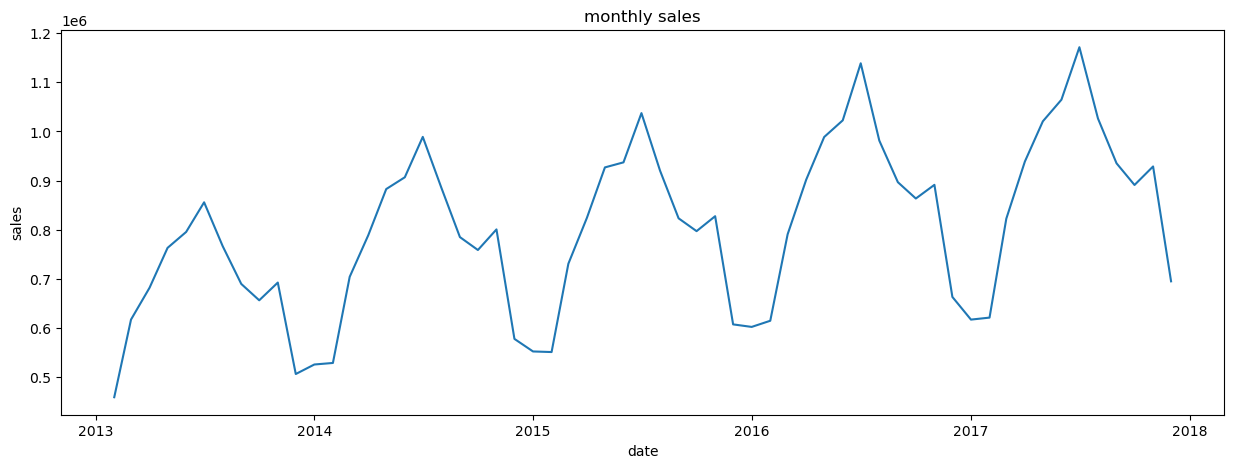

In [120]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('monthly sales')
plt.show()

now we calc the sales difference

In [123]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

/var/folders/5j/cwjkz9ys7nqgs7kf9zv82yt40000gn/T/ipykernel_2719/99621493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_sales['sales_diff'] = monthly_sales['sales'].diff()


,date,sales,sales_diff
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0
11,2013-12-01,506607,-186036.0


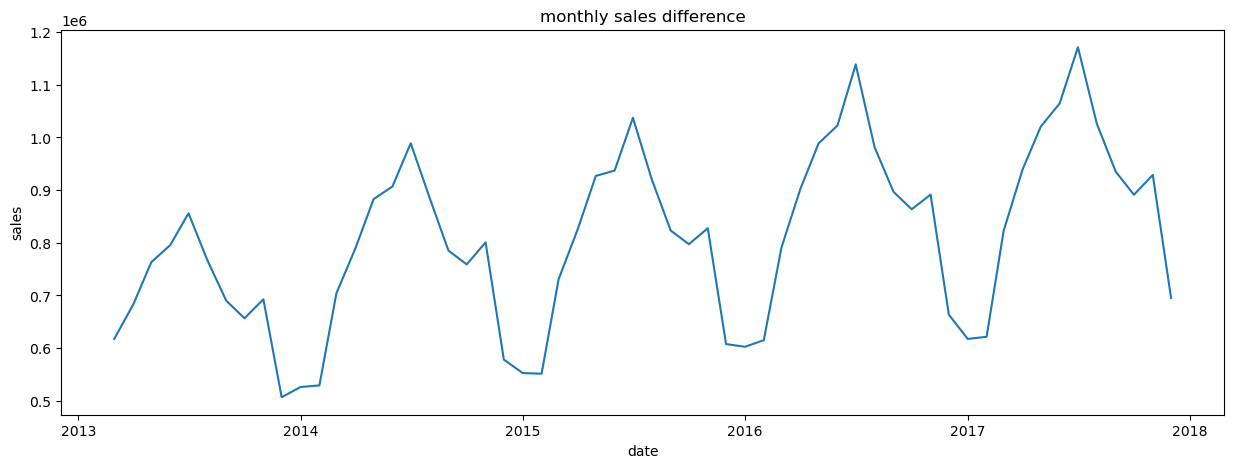

In [124]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('monthly sales difference')
plt.show()

## now we move to prediction models using regression so we get a supervised dataset to train the model

In [125]:
supervised_data = monthly_sales.drop(['date','sales'], axis = 1)

the first 12 months are used for input and then the later are used for output

In [126]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i) 
supervised_data = supervised_data.dropna().reset_index(drop = True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
1,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
2,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
3,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
4,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
5,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
6,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
7,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
8,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0
9,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0


## we have got the sales difference from january to december now we need to split the data into train and test datasets

In [127]:
train_data = supervised_data[:-12] #previous 12 months
test_data = supervised_data[-12:] #next 12 months
print(train_data.shape)
print(test_data.shape)

(34, 13)
(12, 13)


In [128]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [129]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]

In [130]:
y_train = y_train.ravel()
y_test = y_test.ravel()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34, 12)
(34,)
(12, 12)
(12,)


make prediction dataframe to merge the predicted sale prices of all trained algos

In [131]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop = True)
predict_df = pd.DataFrame(sales_dates)

In [132]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


till now we have pre processed the data to be in the form which can be easily used in the linear regression model

In [133]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre = lr_model.predict(x_test)

In [134]:
lr_pre = lr_pre.reshape(-1,1)
#this is a set matrix containing the input features of test set and the predicted output
lr_pre_test_set = np.concatenate([lr_pre,x_test], axis = 1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [135]:
result_list = []
for index in range(0,len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name = "Linear prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

Now using the mean squared error we find the regression pattern closest to our sales giving us the future sales

In [137]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score = (predict_df['Linear prediction'],monthly_sales['sales'][-12:])

print("Linear predicted mse: ",lr_mse)
print("Linear predicted mae: ",lr_mae)
print("Linear predicted r2_score: ",lr_r2)

Linear predicted mse:  16308.94677459162
Linear predicted mae:  12518.321863727799
Linear predicted r2_score:  (0     6.478752e+05
1     6.296918e+05
2     8.197435e+05
3     9.433828e+05
4     1.033676e+06
5     1.065058e+06
6     1.201530e+06
7     1.001867e+06
8     9.412975e+05
9     9.081158e+05
10    9.163515e+05
11    6.948589e+05
Name: Linear prediction, dtype: float64, 48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: sales, dtype: int64)


visualizing the returned outputs

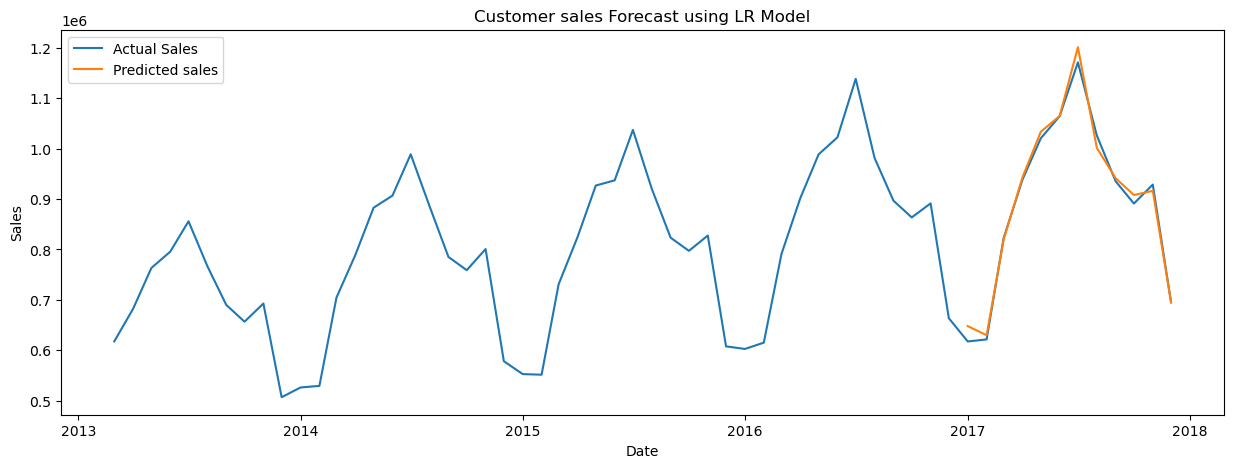

In [145]:
plt.figure(figsize=(15,5))
# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales
plt.plot(predict_df['date'], prtyouedict_df['Linear prediction'])
plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted sales'])
plt.show()

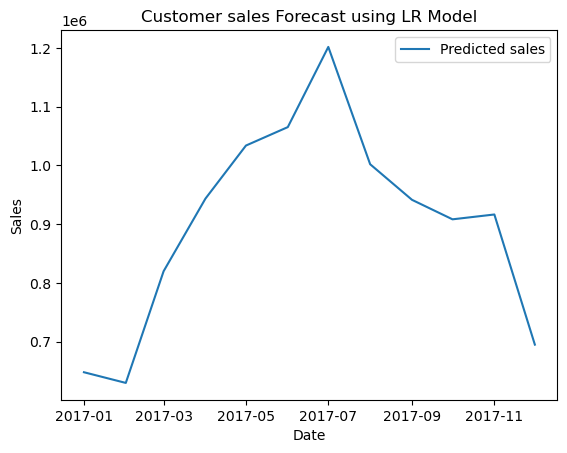

In [148]:
plt.plot(predict_df['date'], predict_df['Linear prediction'])
plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Predicted sales'])
plt.show()

In [149]:
print("predicted sales: ",predict_df)

predicted sales:           date  Linear prediction
0  2017-01-01       6.478752e+05
1  2017-02-01       6.296918e+05
2  2017-03-01       8.197435e+05
3  2017-04-01       9.433828e+05
4  2017-05-01       1.033676e+06
5  2017-06-01       1.065058e+06
6  2017-07-01       1.201530e+06
7  2017-08-01       1.001867e+06
8  2017-09-01       9.412975e+05
9  2017-10-01       9.081158e+05
10 2017-11-01       9.163515e+05
11 2017-12-01       6.948589e+05
